## Classification 

### Making Data

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch

In [104]:
from sklearn.datasets import make_circles

n_samples = 1000

X , y = make_circles(n_samples,noise=0.03,random_state = 42)

In [105]:
len(X),len(y)

(1000, 1000)

In [106]:
print(f"Samples of X: {X[:5]}")
print(f"Samples of y: {y[:5]}")

Samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Samples of y: [1 1 1 1 0]


In [107]:
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})

In [108]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


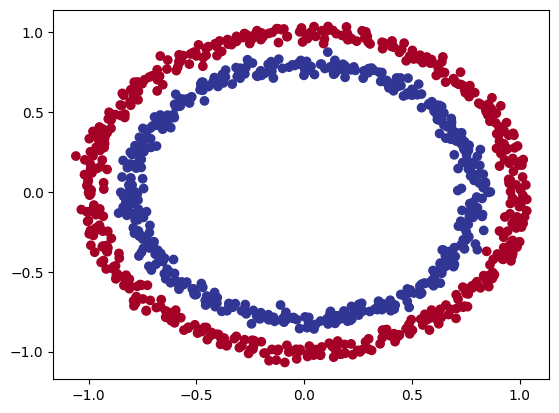

In [109]:
plt.scatter(x=X[:,0],
            y=X [:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [110]:
X.shape,y.shape

((1000, 2), (1000,))

In [111]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [112]:
X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [113]:
from sklearn.model_selection import  train_test_split

In [114]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [115]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

### Building Model

In [116]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [117]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shape of the data
        self.layer_1 = nn.Linear(in_features=2,out_features=5) # takes in 2 features and upscales to 5 features
        self.layers_2 = nn.Linear(in_features=5,out_features=1) # takes in 5 features from previous layer and outputs 1 feature
        # 3. Define a forward() method that outlines the forward pass
        def forward(self,x):
            return self.layer_2(self.layer_1(x))
model_0 = CircleModelV1().to(device)
model_0
            

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layers_2): Linear(in_features=5, out_features=1, bias=True)
)

In [118]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [119]:
#Make a prediction
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [120]:
untrained_preds = model_0(X_test.to(device))
untrained_preds[:10]

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], grad_fn=<SliceBackward0>)

### Setup Loss Function and optimizer

In [121]:
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [122]:
# Calcuate the accuracy - out of 100 samples, how many are predicted correctly
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

### Training Model
1. Forward pass
2. Caluculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer (gradient descent)
 

In [123]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], grad_fn=<SliceBackward0>)

In [124]:
# Use sigmoid on logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], grad_fn=<SigmoidBackward0>)

In [125]:
y_preds = torch.round(y_pred_probs)

In [126]:
print(torch.eq(y_preds.squeeze(),y_test[:5].to(device)))

tensor([False,  True,  True,  True,  True])


In [127]:
torch.manual_seed(42)

In [128]:
# Set number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device) , y_train.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

In [129]:
# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    ## 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    ## 2. Calculate loss/accuracy
    loss = loss_fn(y_logits,
                   y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
    # 3.  Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss Backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing 
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} % | Test loss: {test_loss:.5f}, Test acc: {test_acc: .2f} %")
    

Epoch: 0 | Loss: 0.69796, Acc: 51.88 % | Test loss: 0.69440, Test acc:  58.00 %
Epoch: 10 | Loss: 0.69590, Acc: 51.25 % | Test loss: 0.69305, Test acc:  53.00 %
Epoch: 20 | Loss: 0.69490, Acc: 51.62 % | Test loss: 0.69254, Test acc:  49.50 %
Epoch: 30 | Loss: 0.69435, Acc: 51.12 % | Test loss: 0.69236, Test acc:  49.50 %
Epoch: 40 | Loss: 0.69401, Acc: 50.88 % | Test loss: 0.69232, Test acc:  51.00 %
Epoch: 50 | Loss: 0.69378, Acc: 50.25 % | Test loss: 0.69234, Test acc:  50.00 %
Epoch: 60 | Loss: 0.69362, Acc: 50.00 % | Test loss: 0.69239, Test acc:  51.50 %
Epoch: 70 | Loss: 0.69351, Acc: 50.25 % | Test loss: 0.69246, Test acc:  51.00 %
Epoch: 80 | Loss: 0.69342, Acc: 49.88 % | Test loss: 0.69254, Test acc:  50.00 %
Epoch: 90 | Loss: 0.69336, Acc: 49.88 % | Test loss: 0.69262, Test acc:  53.00 %
Epoch: 100 | Loss: 0.69331, Acc: 49.25 % | Test loss: 0.69271, Test acc:  53.00 %
Epoch: 110 | Loss: 0.69327, Acc: 49.75 % | Test loss: 0.69279, Test acc:  54.00 %
Epoch: 120 | Loss: 0.69324,

Text(0.5, 1.0, 'Predicted')

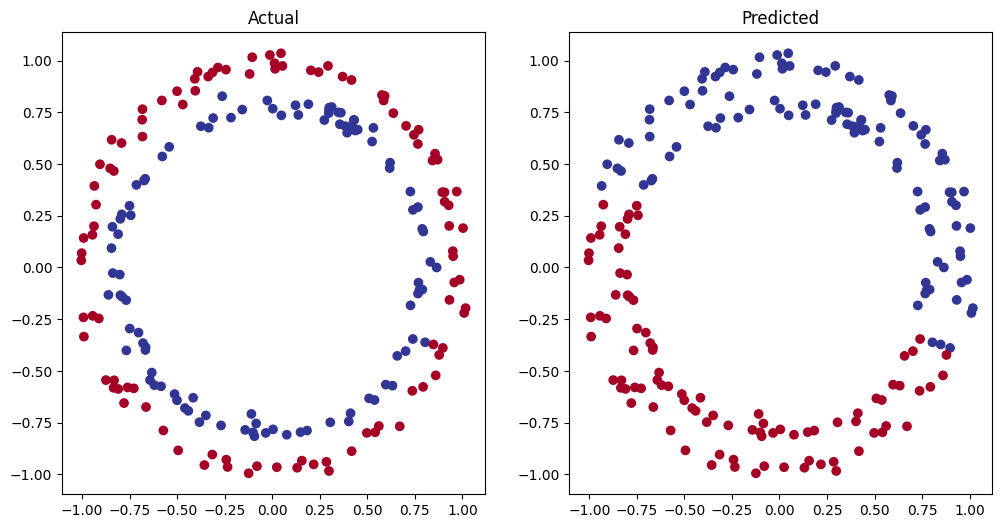

In [130]:
# Plot predictions
model_0.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y_test.cpu(), cmap=plt.cm.RdYlBu)
plt.title("Actual")

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y_preds.cpu(), cmap=plt.cm.RdYlBu)
plt.title("Predicted")

### Model 2

Epoch: 0 | Loss: 0.69295, Acc: 50.00 % | Test loss: 0.69319, Test acc:  50.00 %
Epoch: 10 | Loss: 0.69248, Acc: 50.00 % | Test loss: 0.69260, Test acc:  50.00 %
Epoch: 20 | Loss: 0.69225, Acc: 50.00 % | Test loss: 0.69231, Test acc:  56.50 %
Epoch: 30 | Loss: 0.69209, Acc: 50.00 % | Test loss: 0.69212, Test acc:  68.00 %
Epoch: 40 | Loss: 0.69195, Acc: 50.00 % | Test loss: 0.69195, Test acc:  71.00 %
Epoch: 50 | Loss: 0.69181, Acc: 50.00 % | Test loss: 0.69177, Test acc:  58.00 %
Epoch: 60 | Loss: 0.69168, Acc: 50.00 % | Test loss: 0.69161, Test acc:  54.50 %
Epoch: 70 | Loss: 0.69155, Acc: 50.00 % | Test loss: 0.69146, Test acc:  53.00 %
Epoch: 80 | Loss: 0.69141, Acc: 50.00 % | Test loss: 0.69132, Test acc:  53.00 %
Epoch: 90 | Loss: 0.69128, Acc: 50.00 % | Test loss: 0.69117, Test acc:  53.00 %
Epoch: 100 | Loss: 0.69115, Acc: 50.00 % | Test loss: 0.69102, Test acc:  52.50 %
Epoch: 110 | Loss: 0.69103, Acc: 50.00 % | Test loss: 0.69088, Test acc:  53.50 %
Epoch: 120 | Loss: 0.69090,

Text(0.5, 1.0, 'Predicted')

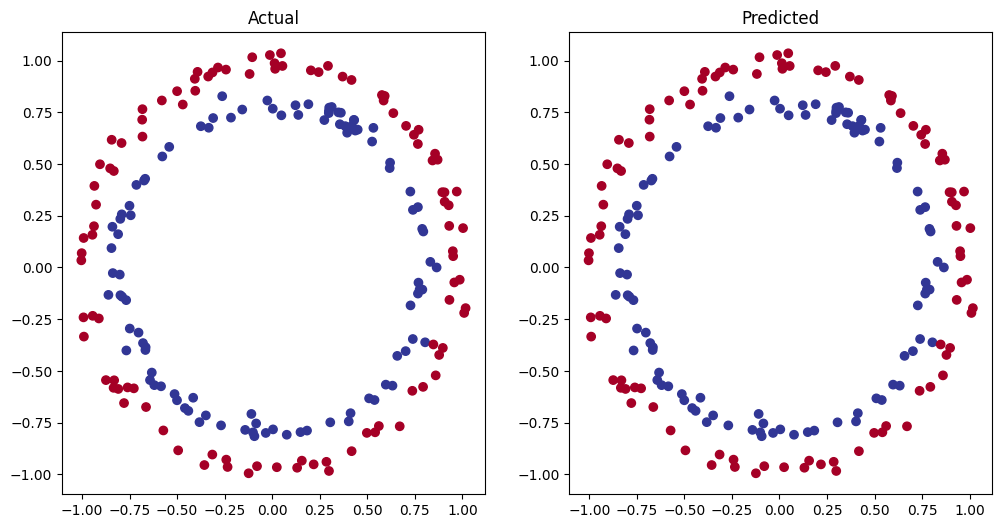

In [131]:
class CircularModel_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features = 10)
        self.layer_2 = nn.Linear(in_features=10,out_features = 10)
        self.layer_3 = nn.Linear(in_features=10,out_features = 1)
        self.relu = nn.ReLU()
    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_v2 = CircularModel_v2().to(device)
model_v2

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_v2.parameters(),lr=0.1)
torch.manual_seed(42)

# Set number of epochs
epochs = 2000

# Put data to target device
X_train, y_train = X_train.to(device) , y_train.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_v2.train()
    ## 1. Forward pass
    y_logits = model_v2(X_train).squeeze()
    y_pred = torch.round(y_logits)
    ## 2. Calculate loss/accuracy
    loss = loss_fn(y_logits,
                   y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
    # 3.  Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss Backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing 
    model_v2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_v2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} % | Test loss: {test_loss:.5f}, Test acc: {test_acc: .2f} %")
        
# Plot predictions
model_v2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_v2(X_test))).squeeze()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y_test.cpu(), cmap=plt.cm.RdYlBu)
plt.title("Actual")

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y_preds.cpu(), cmap=plt.cm.RdYlBu)
plt.title("Predicted")

## Multiclass Classification

In [132]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set Hyperparameters for data
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [133]:
# 1. Create Data
X_blob, y_blob =  make_blobs(n_samples = 1000,
                               n_features = NUM_FEATURES,
                               centers=NUM_CLASSES,cluster_std=1.5,
                               random_state = RANDOM_SEED
                               )

In [134]:
# 2. Turn Data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [135]:
# 3. Splitting into train and test
X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,y_blob,train_size=0.8,random_state=RANDOM_SEED)

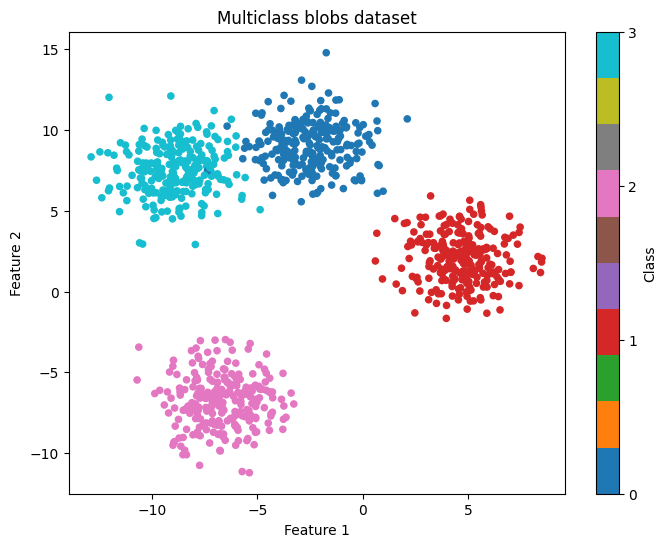

In [136]:
# 4. Plot the data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_blob[:, 0].numpy(), X_blob[:, 1].numpy(), c=y_blob.numpy(), cmap="tab10", s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Multiclass blobs dataset")
plt.colorbar(scatter, ticks=range(NUM_CLASSES), label="Class")
plt.show()

In [137]:
# Creating a Multiclass Classification Model
device = "cpu"
class BlobModel(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=8):
        """Initializes multi-class classification model
        
        Args:
        input_features(int) : Number of input features of the model
        output_features(int) : Number of output features of the model
        hidden_units(int) : Number of hidden units in layers of the model"""
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features,out_features = hidden_units),
            nn.Linear(in_features = hidden_units,out_features = hidden_units),
            nn.Linear(in_features = hidden_units,out_features = output_features)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)
        

model_4 = BlobModel(input_features=2,
                    output_features = 4,
                    hidden_units=8).to(device)
        
print(model_4)
print(model_4.state_dict())


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)
OrderedDict({'linear_layer_stack.0.weight': tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998]]), 'linear_layer_stack.0.bias': tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691]), 'linear_layer_stack.1.weight': tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
        [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
        [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
        [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
        [ 0.1118, -0.0062,  0.276

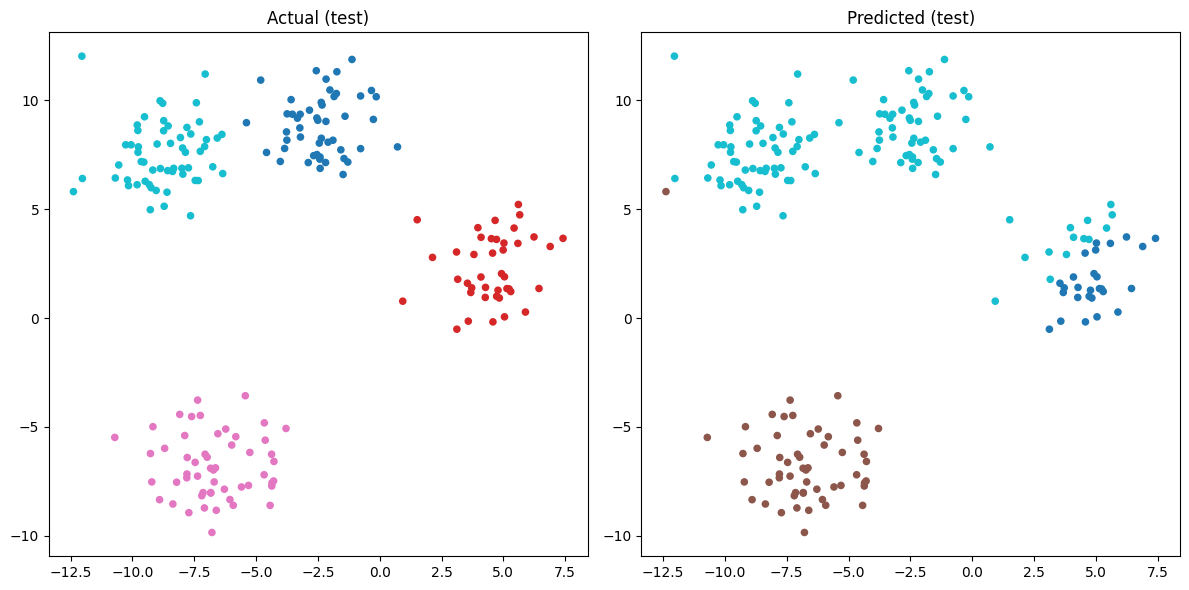

In [138]:
# Predicting Without Training the model

model_4.eval()
with torch.inference_mode():
    test_logits = model_4(X_blob_test.to(device))
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_blob_test[:, 0].numpy(), X_blob_test[:, 1].numpy(), c=y_blob_test.numpy(), cmap="tab10", s=20)
plt.title("Actual (test)")

plt.subplot(1, 2, 2)
plt.scatter(X_blob_test[:, 0].numpy(), X_blob_test[:, 1].numpy(), c=test_pred.cpu().numpy(), cmap="tab10", s=20)
plt.title("Predicted (test)")

plt.tight_layout()

In [139]:
# Calcuate the accuracy - out of 100 samples, how many are predicted correctly
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [140]:
# Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),lr=0.1)

torch.manual_seed(42)

epochs=100
# Put Data to the target device
X_blob_train,y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ## Training Loop
    model_4.train()
    # Forward Pass
    y_logits=model_4(X_blob_train)
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
    # Calcuate Loss
    loss = loss_fn(y_logits,y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,y_pred=y_pred)
    # Optimizer
    optimizer.zero_grad()
    # Loss Backwards
    loss.backward()
    # Progress the potimizer
    optimizer.step()
    
    ## Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits,y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,y_pred=test_pred)
        
        # Print What's Happenin
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} % | Test loss: {test_loss:.5f}, Test acc: {test_acc: .2f} %")
        
        
    


Epoch: 0 | Loss: 1.04324, Acc: 65.50 % | Test loss: 0.57861, Test acc:  95.50 %
Epoch: 10 | Loss: 0.14398, Acc: 99.12 % | Test loss: 0.13037, Test acc:  99.00 %
Epoch: 20 | Loss: 0.08062, Acc: 99.12 % | Test loss: 0.07216, Test acc:  99.50 %
Epoch: 30 | Loss: 0.05924, Acc: 99.12 % | Test loss: 0.05133, Test acc:  99.50 %
Epoch: 40 | Loss: 0.04892, Acc: 99.00 % | Test loss: 0.04098, Test acc:  99.50 %
Epoch: 50 | Loss: 0.04295, Acc: 99.00 % | Test loss: 0.03486, Test acc:  99.50 %
Epoch: 60 | Loss: 0.03910, Acc: 99.00 % | Test loss: 0.03083, Test acc:  99.50 %
Epoch: 70 | Loss: 0.03643, Acc: 99.00 % | Test loss: 0.02799, Test acc:  99.50 %
Epoch: 80 | Loss: 0.03448, Acc: 99.00 % | Test loss: 0.02587, Test acc:  99.50 %
Epoch: 90 | Loss: 0.03300, Acc: 99.12 % | Test loss: 0.02423, Test acc:  99.50 %


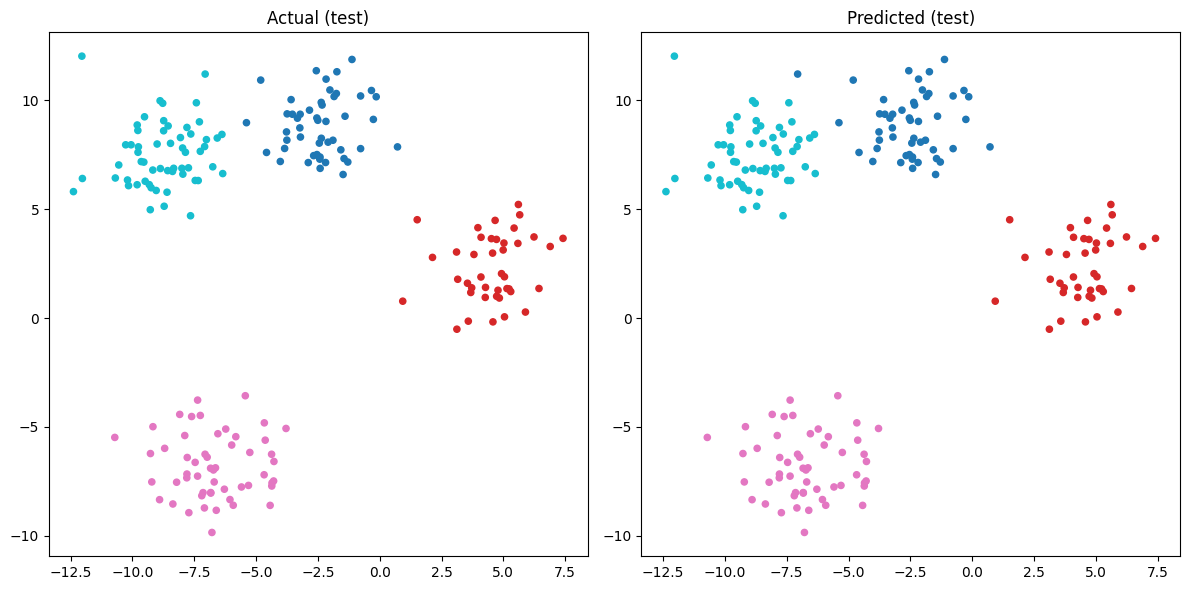

In [141]:
# Predicting Without Training the model

model_4.eval()
with torch.inference_mode():
    test_logits = model_4(X_blob_test.to(device))
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_blob_test[:, 0].numpy(), X_blob_test[:, 1].numpy(), c=y_blob_test.numpy(), cmap="tab10", s=20)
plt.title("Actual (test)")

plt.subplot(1, 2, 2)
plt.scatter(X_blob_test[:, 0].numpy(), X_blob_test[:, 1].numpy(), c=test_pred.cpu().numpy(), cmap="tab10", s=20)
plt.title("Predicted (test)")

plt.tight_layout()